# Decision Trees: Predictor Importance

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
import time

sns.set_style("whitegrid")

In [2]:
T = pd.read_csv("./data/pumpFeatures.csv")
X, y = T.iloc[:, :-1], T.faultCode
T.head()

,wMotor_mean,wMotor_std,wMotor_fftPeakIdx,wMotor_skewness,wMotor_kurtosis,wMotor_peak2peak,wMotor_peak2rms,wMotor_rms,wMotor_mad,wMotor_csRange,...,pOut_peak2peak,pOut_peak2rms,pOut_rms,pOut_mad,pOut_csRange,pOut_pLow,pOut_pMid,pOut_pHigh,pOut_pKur,faultCode
0,876.235677,6.204772,762,-0.164601,2.881123,39.070726,1.018288,876.257629,5.032113,1.225859e+06,...,0.125500,1.007635,7.226002,0.019002,10109.108199,0.000091,0.007472,0.001348,0.076296,0
1,876.238247,6.077463,762,-0.147077,2.673731,34.570767,1.016957,876.259308,4.982643,1.225862e+06,...,0.120924,1.007091,7.225622,0.018990,10108.578309,0.000118,0.006954,0.001434,0.076296,0
2,876.031159,6.250861,762,-0.123501,2.551445,35.491460,1.017266,876.053444,5.165914,1.225575e+06,...,0.131161,1.007494,7.225906,0.019032,10108.963684,0.000060,0.006570,0.001309,0.076296,0
3,876.196665,6.247495,762,-0.134596,2.728913,41.529486,1.018873,876.218921,5.093603,1.225799e+06,...,0.123254,1.007770,7.225914,0.018717,10108.973834,0.000066,0.007190,0.001364,0.076296,0
4,876.199734,6.095278,762,-0.139257,2.705275,36.096733,1.018066,876.220919,4.962708,1.225812e+06,...,0.123759,1.006735,7.225260,0.019078,10108.065292,0.000051,0.007814,0.001600,0.071808,0


This code fits a 5-fold cross-validated classification tree model to the original data and calculates the accuracy.

In [3]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=5, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.845 0.91  0.845 0.885 0.885]
Mean accuracy: 0.8739999999999999
Cross validation elapsed time: 0.2179 seconds


We can use the [permutation_importance()](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn-inspection-permutation-importance) function on a decision tree model to calculate the importance of each predictor variable.

In [4]:
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(X, y)

feature_importances = permutation_importance(classifier, X, y, n_repeats=10, random_state=0)
feature_importances = pd.DataFrame({'features': X.columns, 'importances_mean': feature_importances['importances_mean'], 
                                    'importances_std': feature_importances['importances_std']})
feature_importances.head()

,features,importances_mean,importances_std
0,wMotor_mean,0.0000,0.000000
1,wMotor_std,0.0000,0.000000
2,wMotor_fftPeakIdx,0.0000,0.000000
3,wMotor_skewness,0.0000,0.000000
4,wMotor_kurtosis,0.0025,0.000806


We can determine which predictors to keep by setting a threshold for importance.

<Figure size 640x480 with 0 Axes>

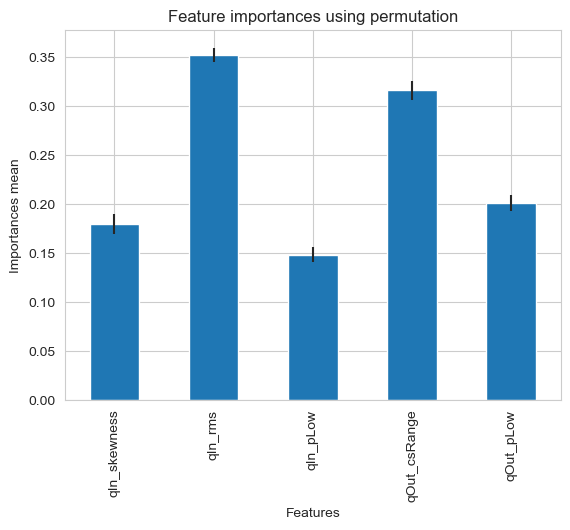

In [5]:
threshold = 0.1
fetures_keep = feature_importances['importances_mean'] > threshold

plt.figure()
feature_importances[fetures_keep].plot.bar(x='features', y='importances_mean', yerr='importances_std', legend=None)
plt.title("Feature importances using permutation")
plt.xlabel("Features")
plt.ylabel("Importances mean")
plt.show()

In [6]:
X_selected = X[X.columns[fetures_keep]]
X_selected.head()

,qIn_skewness,qIn_rms,qIn_pLow,qOut_csRange,qOut_pLow
0,1.446847,35.752511,72.180686,49707.083608,1.306950
1,1.463178,35.784340,76.300590,49745.621125,0.637924
2,1.464698,35.781533,68.855755,49746.636093,0.629772
3,1.503273,35.723558,73.583629,49655.781850,0.561285
4,1.409252,35.768517,80.285172,49726.524042,0.696649


In [7]:
classifier = DecisionTreeClassifier()
kf = KFold(n_splits=5, shuffle=True)

start_time = time.time()
cv_results = cross_validate(classifier, X_selected, y, cv=kf)
elapsed_time = time.time() - start_time

print("Accuracies:", cv_results['test_score'])
print("Mean accuracy:", cv_results['test_score'].mean())
print(f"Cross validation elapsed time: {elapsed_time:.4f} seconds")

Accuracies: [0.92  0.87  0.905 0.855 0.905]
Mean accuracy: 0.891
Cross validation elapsed time: 0.0342 seconds
